# **PROJECT: Pneumonia Detection**

# **AUTHOR: AAMIR P**

# **ORGANISATION: PANIMALAR ENGINEERING COLLEGE**

# **FINAL YEAR PROJECT**

**IMPORT JSON FILE**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aamirp","key":"431b35661fcf4f3090884a16b1e4e5fc"}'}

In [3]:
# Make sure the json file is present
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Dec 31 18:23 kaggle.json


In [4]:
#install API
!pip install -q kaggle

In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

**UNZIP THE FILE**

In [7]:
credentials = {"username":"aamirp","key":"431b35661fcf4f3090884a16b1e4e5fc"}
os.environ['KAGGLE_KEY']=credentials["key"]
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

**IMPORT LIBRARIES**

In [21]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator

**LOAD IMAGE DATA**

In [22]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

**LOAD TRAIN DATA**

In [25]:
norm_images, norm_labels = load_normal('/content/chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('/content/chest_xray/train/PNEUMONIA/')


100%|██████████| 3875/3875 [00:43<00:00, 89.64it/s]


**CONCATENATE**

In [26]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)


**SHAPE OF FEATURE**

In [27]:
X_train.shape

(5216, 200, 200)

**SHAPE OF LABEL**

In [28]:
y_train.shape

(5216,)

**NUMBER OF IMAGES**

In [29]:
np.unique(y_train,return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345]))

**PREPROCESSING**

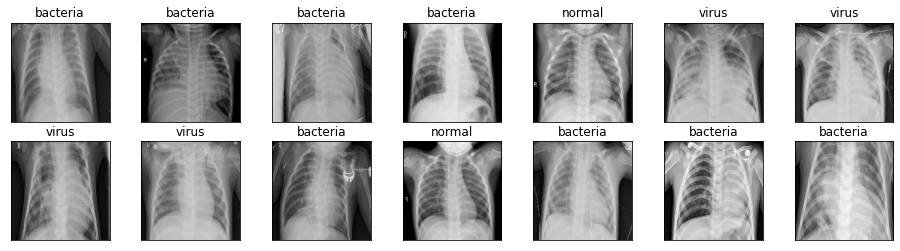

In [30]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

**LOAD TEST IMAGES**

In [31]:
norm_images_test, norm_labels_test = load_normal('/content/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('/content/chest_xray/test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:03<00:00, 104.01it/s]


In [32]:
# Use this to save variables
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

**LABEL PREPROCESSING**

In [33]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [34]:
one_hot_encoder = OneHotEncoder(sparse=False)


In [35]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

**RESHAPING**

In [36]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

**DATA AUGMENTATION**

In [37]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [39]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)


**Convolutional Neural Network**

In [40]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

In [41]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

**TRAINING**

In [42]:
history = model.fit_generator(train_gen, epochs=30, 
          validation_data=(X_test, y_test_one_hot))

Epoch 1/30
163/163 [==============================] - 368s 2s/step - loss: 4.4594 - acc: 0.5972 - val_loss: 0.7275 - val_acc: 0.7500
Epoch 2/30
163/163 [==============================] - 359s 2s/step - loss: 0.6915 - acc: 0.7076 - val_loss: 0.9423 - val_acc: 0.6795
Epoch 3/30
163/163 [==============================] - 358s 2s/step - loss: 0.6397 - acc: 0.7247 - val_loss: 0.7584 - val_acc: 0.7292
Epoch 4/30
163/163 [==============================] - 357s 2s/step - loss: 0.6236 - acc: 0.7304 - val_loss: 0.7095 - val_acc: 0.7692
Epoch 5/30
163/163 [==============================] - 357s 2s/step - loss: 0.6092 - acc: 0.7431 - val_loss: 0.7095 - val_acc: 0.7740
Epoch 6/30
163/163 [==============================] - 357s 2s/step - loss: 0.5913 - acc: 0.7502 - val_loss: 0.7818 - val_acc: 0.7740
Epoch 7/30
163/163 [==============================] - 365s 2s/step - loss: 0.5755 - acc: 0.7523 - val_loss: 0.9389 - val_acc: 0.7420
Epoch 8/30
163/163 [==============================] - 357s 2s/step - 

**ACCURACY**

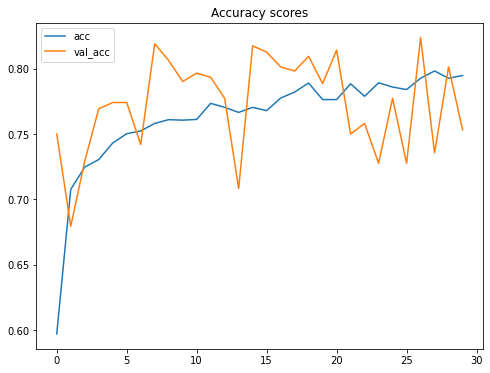

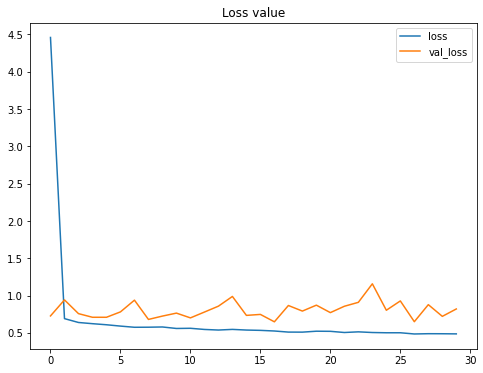

In [44]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

**MODEL EVALUATION**

In [45]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

**CONFUSION MATRIX**

In [46]:
cm = confusion_matrix(y_test, predictions)


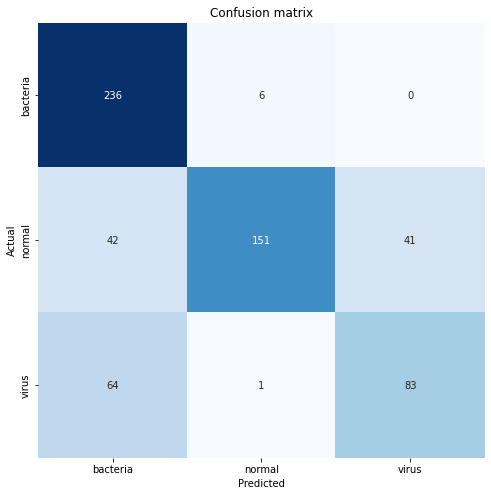

In [48]:
classnames = ['bacteria', 'normal', 'virus']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()